In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from classical_code import *
from utils import get_logicals
import stim
from scipy.sparse import lil_matrix
from ldpc import bposd_decoder, bp_decoder
from tqdm import tqdm
from result import Result, save_new_res
# %load_ext snakeviz

In [84]:
GF = galois.GF(2)
ccode = read_code("./codes/16_12_3_4.code")
H = np.zeros((ccode.m, ccode.n), dtype=int)
for i in range(ccode.m):
    for j in range(ccode.n):
        if (j in ccode.check_nbhd[i]):
            H[i][j] = 1
dim0, dim1 = H.shape
print(H)
print(dim1 - np.linalg.matrix_rank(GF(H)))

[[0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1]
 [1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0]
 [0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0]
 [0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0]
 [1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0]]
4


In [85]:
I1 = np.eye(dim1, dtype=int)
I0 = np.eye(dim0, dtype=int)

dE21 = np.kron(H, I0)
dE22 = np.kron(I1, H.T)
dE2 = np.vstack([dE21, dE22])
Hz = dE2.T

dE11 = np.kron(I0, H.T)
dE12 = np.kron(H, I1)
dE1 = np.hstack([dE11, dE12])
Hx = dE1

m, n = Hx.shape

print(Hz.shape)

(192, 400)


(196, 400)


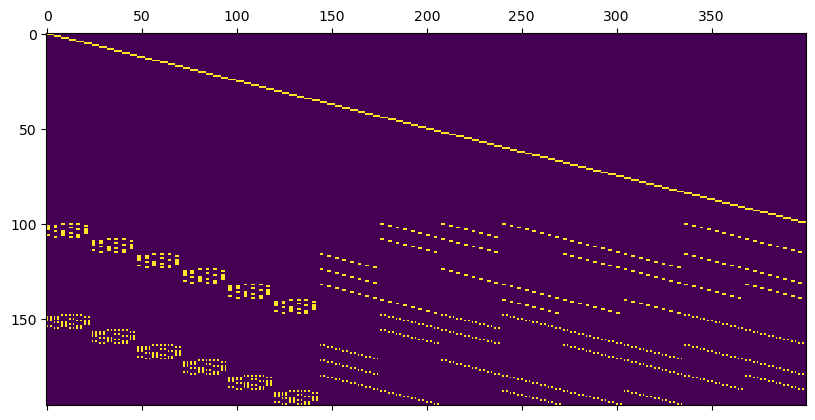

In [128]:
Hx = np.loadtxt("codes/Hx.txt", dtype=int)
Hz = np.loadtxt("codes/Hz.txt", dtype=int)
m, n = Hx.shape

# Hx = np.hstack([Hx, np.eye(Hx.shape[0], dtype=int)])
print(Hz.shape)
plt.matshow(Hx)

In [151]:
overlapping_x_generators = np.empty(100, dtype=object)
for i in range(100):
    tmp = np.array([], dtype=int)
    for j in range(100,196):
        if np.any(Hx[i] & Hx[j]): tmp = np.append(tmp, j)
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(100, dtype=object)
# for i in range(concatenatedStabilizersQED.shape[0]):
#     tmp = np.array([], dtype=int)
#     for j in range(concatenatedStabilizersZQEC.shape[0]):
#         if np.any(concatenatedStabilizersQED[i] & concatenatedStabilizersZQEC[j]): tmp = np.append(tmp, j+concatenatedStabilizersQED.shape[0])
#     overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False, not_overlapping=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])

    if not_overlapping:
        return np.array(list(set(np.arange(100,196)) ^ gens_to_measure))
    else:
        return np.array(list(gens_to_measure))

In [129]:
zL = get_logicals(Hx, Hz, False)
xL = get_logicals(Hx, Hz, True)
k = len(xL)

xL_inds = [np.where(x)[0] for x in xL]
zL_inds = [np.where(z)[0] for z in zL]

print(len(xL))
print(Hx.shape[1] - np.linalg.matrix_rank(Hx) - np.linalg.matrix_rank(Hz))

8
8


In [166]:
qubit_error_rate = 0.005
meas_error_rate = 0.002

bp_qed_dec = bposd_decoder(
    Hx[:100], # the parity check matrix
    error_rate=qubit_error_rate,
    # channel_probs=new_channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=1000, #pcm.shape[1], #the maximum number of iterations for BP)
    bp_method="ps",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    # osd_order=40 #the osd search depth
)

bp_qed_qec_dec = bp_decoder(
    Hx,
    error_rate=qubit_error_rate,
    bp_method="ps",
    max_iter=1000,
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    # osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    # osd_order=40 #the osd search depth
)

bp_qec_dec = bposd_decoder(
    Hx,
    error_rate=qubit_error_rate,
    bp_method="ps",
    max_iter=1000,
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    # osd_order=40 #the osd search depth
)

In [ ]:
rs = []
tmp = []
for ii in range(1,1001):
    num_rounds = 0
    residual_error = np.zeros(Hx.shape[1], dtype=int)

    while True:
        num_rounds += 1
        new_qubit_error = np.random.choice([0, 1], size=Hx.shape[1], p=[1-qubit_error_rate, qubit_error_rate])
        new_synd_error = np.random.choice([0, 1], size=Hx.shape[0], p=[1-meas_error_rate, meas_error_rate])
        curr_qubit_error = residual_error ^ new_qubit_error
        curr_synd = ((Hx @ curr_qubit_error) % 2) ^ new_synd_error

        guessed_error = bposd_dec.decode(curr_synd)
        residual_error = curr_qubit_error ^ guessed_error
        # ideal_correction = bposd_dec.decode((Hx @ residual_error) % 2)

        obs = [np.count_nonzero(residual_error[l]) % 2 for l in zL_inds]
        # obs = [np.count_nonzero((ideal_correction ^ residual_error)[l]) % 2 for l in zL_inds]

        if np.any(obs):
            break

    res = Result(0, n, k, qubit_error_rate, meas_error_rate, 1, num_rounds, 0)
    rs.append(res)
    tmp.append(num_rounds)

    if (ii%100==0):
        save_new_res('results/tmp.res', rs)
        rs = []
print(np.mean(tmp))

In [167]:
successes = 0
successes2 = 0

for ii in range(1,10001):
    if (ii % 1000 == 0): print('*', end='')
    residual_error = np.zeros(Hx.shape[1], dtype=int)

    success = 1
    success2 = 1
    for jj in range(1):
        new_qubit_error = np.random.choice([0, 1], size=Hx.shape[1], p=[1-qubit_error_rate, qubit_error_rate])
        new_synd_error = np.random.choice([0, 1], size=Hx.shape[0], p=[1-meas_error_rate, meas_error_rate])
        curr_qubit_error = residual_error ^ new_qubit_error
        curr_synd = ((Hx @ curr_qubit_error) % 2) ^ new_synd_error

        # QEC
        guessed_error = bp_qec_dec.decode(curr_synd)

        # QED + QEC
        initial_guess = bp_qed_dec.decode(curr_synd[:100])

        ########################
        # new_channel_probs = np.exp(-bp_qed_dec.log_prob_ratios) # THIS MIGHT NEED TO CHANGE SLIGHTLY
        # new_channel_probs = new_channel_probs / np.sum(new_channel_probs)
        new_channel_probs = 1 / (np.exp(bp_qed_dec.log_prob_ratios) + 1)
        new_channel_probs = new_channel_probs / np.sum(new_channel_probs)
        # new_channel_probs[400:] = meas_error_rate
        bp_qed_qec_dec.update_channel_probs(new_channel_probs)
        ########################

        updated_synd = curr_synd.copy()
        updated_synd[get_overlapping(curr_synd[:100], True, True)] = 0

        guessed_error2 = bp_qed_qec_dec.decode(updated_synd)

        residual_error = curr_qubit_error ^ guessed_error
        residual_error2 = curr_qubit_error ^ guessed_error2


    # print()
    obs = [np.count_nonzero(residual_error[l]) % 2 for l in zL_inds]
    obs2 = [np.count_nonzero(residual_error2[l]) % 2 for l in zL_inds]

    # if np.any(obs2) and not np.any(obs):
    #     print(np.where(curr_qubit_error)[0])
    #     print(np.where(guessed_error)[0])
    #     print("+++", np.where(Hx[:100][curr_synd[:100] == 1])[1])
    #     print(np.where(guessed_error2)[0])
    #     print()
    #     break
    if np.any(obs2):
        success2 = 0
    if np.any(obs):
        success = 0

    successes += success
    successes2 += success2

print()
print(successes, successes2)

**********
9495 9925


In [136]:
residual_error = np.zeros(Hx.shape[1], dtype=int)

new_qubit_error = np.random.choice([0, 1], size=Hx.shape[1], p=[1-qubit_error_rate, qubit_error_rate])
new_synd_error = np.random.choice([0, 1], size=Hx.shape[0], p=[1-meas_error_rate, meas_error_rate])
curr_qubit_error = residual_error ^ new_qubit_error
curr_synd = ((Hx @ curr_qubit_error) % 2) #^ new_synd_error

correction = bp_qed_dec.decode(curr_synd[:100])

print(np.where(curr_qubit_error))
print(np.where(bp_qed_dec.log_prob_ratios < 8))

(array([ 10,  21,  95, 137, 214, 353], dtype=int64),)
(array([  8,   9,  10,  11,  20,  21,  22,  23,  92,  93,  94,  95, 136,
       137, 138, 139, 212, 213, 214, 215, 352, 353, 354, 355], dtype=int64),)


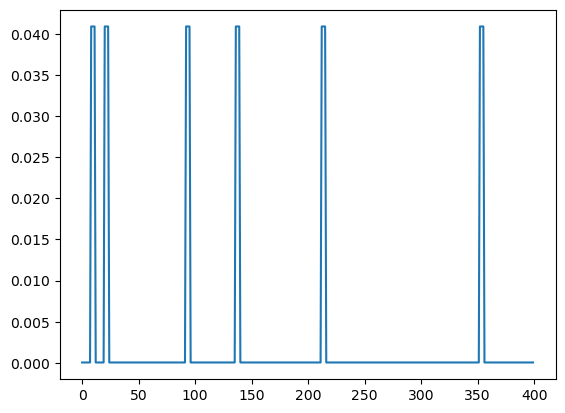

In [137]:
lpr = bp_qed_dec.log_prob_ratios
frequencies = 1 / (np.exp(lpr) + 1)
frequencies = frequencies / np.sum(frequencies)
# frequencies[400:] = meas_error_rate

plt.plot(frequencies)

In [147]:
get_overlapping(curr_synd[:100], True)

[128,
 129,
 194,
 195,
 191,
 136,
 140,
 143,
 146,
 147,
 148,
 149,
 151,
 152,
 153,
 154,
 157,
 184,
 100,
 101,
 103,
 104,
 105,
 106,
 168,
 173,
 109,
 175,
 176,
 177,
 120,
 188,
 125,
 127]

In [150]:
get_overlapping(curr_synd[:100], True, True)

array({100, 104, 105, 108, 109, 110, 111, 112, 113, 114, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 152, 153, 156, 157, 158, 159, 160, 161, 162, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195},
      dtype=object)

In [56]:
bp_qec_dec.update_channel_probs(frequencies)
correction = bp_qec_dec.decode(curr_synd)

print(np.where(correction))
print(bp_qec_dec.converge)

(array([ 37, 279, 379, 386, 399], dtype=int64),)
1
